# Generative Modeling 

**Generative adversarial networks (GANs)** are comprised of two models that are trained simultaneously by an adversarial process.  Assume that we have an unlabeled dataset that follows some distribution.  A generator unit learns to create fake data that resembles this distribution and a discriminator unit learns to distinguish between fake data and real data.    

The generator attempts to estimate the distribution of the real data.  Once the GAN is trained, the generator can be used to generate believable fake data.  

## GAN Architecture 

Below is the architecture of a GAN.  In this example, the unlabeled dataset is the MNIST dataset (its the same handwritten digit dataset, we just don't care about the number labels).  The goal of this GAN is to produce images that look like they belong to the MNIST dataset.  

![arch](images/gan-arch.png)


Below are images produced by a discriminator at various phases during training.  Each image on the grid is given a consistent random seed.  Note that each image eventually develops "MNIST-like" metafeatures.   


![training](images/dcgan.gif)

## Example using MNIST 

We're going to implement a deep convolutional generative adversarial network (DCGAN) to generate images that mimick the MNIST dataset.  [Reference here](https://arxiv.org/abs/1511.06434)  
  

In [1]:
import time 
import os 
import numpy as np
import matplotlib.pyplot as plt 

import tensorflow as tf 
from tensorflow.keras import layers 

from PIL import Image 
from IPython import display



### Import MNIST data and preprocess

In [2]:
# Import data using tf interface
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

# Image preprocessing 
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]


In [3]:
BUFFER_SIZE = 60000
BATCH_SIZE = 128

In [4]:
# Prepare tf dataset object 
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### Design models

#### Generator 

The generator takes noise as input (100 random floats) and outputs a 28x28x1 pixel image.   

This generator will use a `Conv2DTranspose` layer, sometimes called Deconvolution.  These are used when you want to transform a volume in the opposite direction to the normal convolution operation (up-sample instead of down-sample).  

More info [here](https://www.machinecurve.com/index.php/2019/09/29/understanding-transposed-convolutions/) 


In [5]:
generator = tf.keras.Sequential()
generator.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Reshape((7, 7, 256)))
assert generator.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

generator.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
assert generator.output_shape == (None, 7, 7, 128)
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
assert generator.output_shape == (None, 14, 14, 64)
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
assert generator.output_shape == (None, 28, 28, 1)

In [6]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

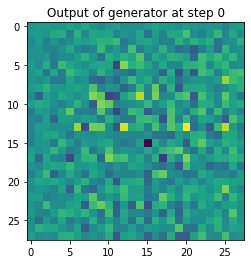

In [7]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0]) 
plt.title('Output of generator at step 0');

#### Discriminator

The discriminator is a typical convolutional network image classifier.  It will take a 28x28x1 image as input and output a logit representing a classification.   

In [8]:
discriminator = tf.keras.Sequential()
discriminator.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                 input_shape=[28, 28, 1]))
discriminator.add(layers.LeakyReLU())
discriminator.add(layers.Dropout(0.3))

discriminator.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
discriminator.add(layers.LeakyReLU())
discriminator.add(layers.Dropout(0.3))

discriminator.add(layers.Flatten())
discriminator.add(layers.Dense(1))

In [9]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [10]:
decision = discriminator(generated_image) 
print(decision)

tf.Tensor([[0.00136858]], shape=(1, 1), dtype=float32)


### Setup models      

In [11]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)  

#### Discriminator Loss

In [12]:
def discriminator_loss(real, fake): 
    """ Calculates discriminator model's loss 
    
    The discriminator distingushes between real and fake images      
    """
    real_loss = cross_entropy(tf.ones_like(real), real)   
    fake_loss = cross_entropy(tf.zeros_like(fake), fake)   
    total_loss = real_loss + fake_loss 
    
    return total_loss 

#### Generator Loss 

In [13]:
def generator_loss(discrim_decision): 
    """ Calculates generator model's loss
    
    The generator's loss quantifies how well it was able to trick the discriminator.  
    We will compare the discriminator's decisions on the generated images to an array of ones
    """
    
    return cross_entropy(tf.ones_like(discrim_decision), discrim_decision)

#### Optimizers 
It is very important for the generator and discriminator to train at similar rates so that one does not overpower the other.  

In [14]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
          

Define model checkpoints 

In [15]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


### Training loop 

In [16]:
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


In [17]:
# The @tf.function decorate tells Python to run some tf code before running this function.
#  That tf code "compiles" the function for performance increase  

@tf.function  
def train_step(images): 
    """ Conduct one step of training (forward pass and backwards pass on one batch)
    """  
    
    # random noise to feed into generator
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    # Tape operations of the generator and discriminator 
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: 
        generated_images = generator(noise, training=True)  
        
        real_output = discriminator(images, training=True)  
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(discrim_decision=fake_output) 
        disc_loss = discriminator_loss(real_output, fake_output)  
        
    # Compute gradients 
    generator_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)  

    
    # Apply optimizer 
    generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables))

    
    

[GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) is a context manager that records operations and watches trainable variables.  The goal is to construct a computation graph in order to compute gradients.   

In [18]:
def train(dataset, epochs): 
    """
    """
    
    for epoch in range(epochs): 
        # tic 
        start = time.time()
        
        
        for image_batch in dataset:
            # Apply one step of training on the GAN 
            train_step(image_batch)
            
            
        # Produce images to compile into a GIF  
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        
        # Save the model every 15 epochs  
        if (epoch + 1) % 15 == 0: 
            checkpoint.save(checkpoint_prefix)
            
        # toc 
        print("Time for epoch {} is {} seconds.".format(epoch + 1, time.time()-start))

    
    display.clear_output(wait=True) 
    generate_and_save_images(generator, epochs, seed)

Function for visualizing output 

In [19]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

    

### Train the model

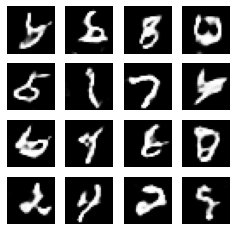

In [20]:
EPOCHS = 50  
train(train_dataset, EPOCHS)  

# References  

+ https://arxiv.org/abs/1406.2661
+ https://www.tensorflow.org/tutorials/generative/dcgan
+ https://arxiv.org/pdf/1701.00160.pdf